In [1]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 5.0 MB/s 


In [24]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.contrib.timeseries as time_gp

import pandas as pd
from tqdm import tqdm
pyro.set_rng_seed(0)

In [3]:
# Helper function for plotting. Source: https://pyro.ai/examples/gp.html
def plot(
    X,
    y,
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
    xlim=None,
    train_test_split=None,
    line_color="r"
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(X[0], X[-1], n_test, dtype=torch.double)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            #color="C0",
            alpha=0.3,
        )
    if train_test_split:
        plt.axvline(x=len(X)-train_test_split)
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    else:
        ax.set_xlim(X[0], X[-1])

In [4]:
T0 = 200

In [11]:
df_price = pd.read_csv('data/BTC-USD.csv', parse_dates=True)
df_price['Adj Close'] = df_price['Adj Close']
data = torch.tensor(df_price['Adj Close'].values, dtype=torch.double)

In [12]:
X = torch.tensor(range(len(data[:-T0])), dtype=torch.double)
y = data[:-T0]

X_test = torch.tensor(range(len(data[-T0:])), dtype=torch.double)
y_test = data[-T0:]




In [29]:
X_full = torch.tensor(range(len(data)), dtype=torch.double)
y_full = data

In [31]:

def plot_loss(loss, log=False, label=None):
    plt.plot(loss, label=label)
    if log:
      plt.yscale('log')
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text
    if label:
      plt.legend()



In [14]:
from copy import deepcopy

## Kernel components used:
Descriptions based on [Duv2014](https://www.cs.toronto.edu/~duvenaud/cookbook/) and [Scikit-learn](https://scikit-learn.org/stable/modules/gaussian_process.html)


### Basic
*   Linear - linearly growing trend, useful mainly for combining with other functions
* Radial Basis Function (RBF) - popular, universal, smooth, in general non-monotonic function
* Rational Quadratic Kernel (RQ) - sum of many RBFs with different lengthscales, used for higher flexibility
* Mattern - generalization of RBF with an additional parameter v for regulating the smoothness of the functions. Explicitly implemented in Pyro for v=3/2 and v=5/2, as for lower values the process becomes too rough and higher values result with a similar effect to the plain RBF (see [Rasmussen](http://gaussianprocess.org/gpml/chapters/RW.pdf), pp. 85)
*   Periodic - repetitive behaviour over time periods
* White Noise

### Combined

In principle, multiplying kernels result in a high kernel value only if all component "sub-kernels" have high values. On the contrary, adding kernels requires at least one component to have a high value to impact the whole sum. In particular, the following combinations were used:
* Locally Periodic - periodic kernel multiplied by a local one (e.g. RBF) to add long-term variation to the basic periodic
* Linear plus (Locally) Periodic - results in functions which are periodic with increasing amplitude as we move away from the origin
* Power of Linear - results in a polynomial regression


### Model 1
Baseline, inspired by [Pyro example](https://pyro.ai/examples/gp.html). In the context of Bitcoin price, linear kernel corresponds to an optimistic assumption that the price generally grows. The locally periodic component corresponds to close-to-regular market fluctuations. 

Kernel: Linear + RBF*Periodic

### Model 2
Instead of RBF, this model uses RQ in order ot have greater flexibility in mixing RBF-like lengthscales. It is hoped to address the fact that quasi-periodic market fluctuations in real life can have higher and varying amplitude than Model 1 assumes.

Kernel: Linear + RQ*Periodic

### Model 3

The local kernel is replaced by Mattern32 (Mattern with v=3/2) to represent short-term volatility of the price (rough RBF functions).

Kernal: Linear + Mattern32*Periodic

#TODO: jeszcze dwa modele, przy czym jeden z white noise. Zrobimy tak, ze te 3 pierwsze to taki punkt wyjscia i potem dwa kolejne to dopieszczanie z jakims white noise itp. Jak czas pozwoli, to kazdy model zrobic w trzech egzemplarzach z roznymi wartosciami poczatkowymi parametrow. Na koniec wziac najlepszy optycznie model i sprobowac jakos zinterpretowac kernele 

In [55]:
#Xu = torch.arange(len(data), dtype=torch.float64)/10.
models_0 = []
pyro.clear_param_store()

models_0.append(gp.models.GPRegression(X=X,y=y,kernel=gp.kernels.Linear(input_dim=1)))

models_0.append(gp.models.GPRegression(X=X,y=y,kernel=gp.kernels.Periodic(input_dim=1)))

models_0.append(gp.models.GPRegression(X=X,y=y,kernel=gp.kernels.RBF(input_dim=1)))
models_0.append(gp.models.GPRegression(X=X,y=y,kernel=gp.kernels.RationalQuadratic(input_dim=1)))
models_0.append(gp.models.GPRegression(X=X,y=y,kernel=gp.kernels.Matern32(input_dim=1)))
models_0.append(gp.models.GPRegression(X=X,y=y,kernel=gp.kernels.WhiteNoise(input_dim=1)))
'''
for model in tqdm(models_0):
  loss = gp.util.train(model, num_steps=5, optimizer=torch.optim.Adam(model.parameters(), lr=0.5))
  plot_loss(loss, log=True)
  '''


'\nfor model in tqdm(models_0):\n  loss = gp.util.train(model, num_steps=5, optimizer=torch.optim.Adam(model.parameters(), lr=0.5))\n  plot_loss(loss, log=True)\n  '

In [60]:
def train_model(model):
  loss = gp.util.train(model, num_steps=5, optimizer=torch.optim.Adam(model.parameters(), lr=0.5))
  print('Model trained!')
  print(model)
  return loss

In [61]:
import multiprocessing as mp

ctx = mp.get_context('spawn')

with ctx.Pool(3) as pool:
  losses = pool.map(train_model,models_0)



Process ForkPoolWorker-25:
Process ForkPoolWorker-24:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocess

KeyboardInterrupt: ignored

In [49]:
Xu = torch.arange(0,len(data), step=10)


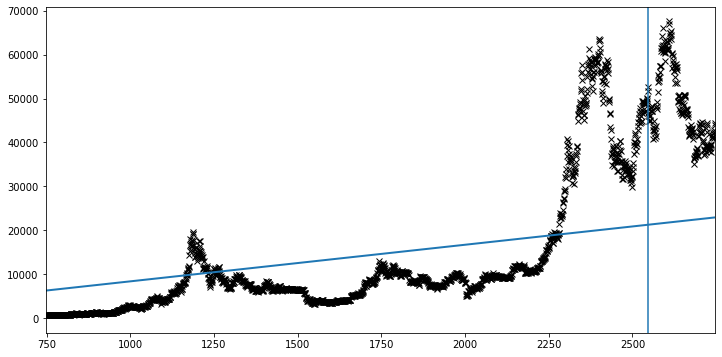

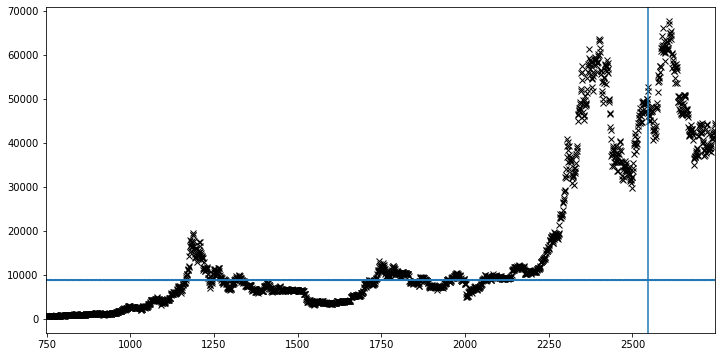

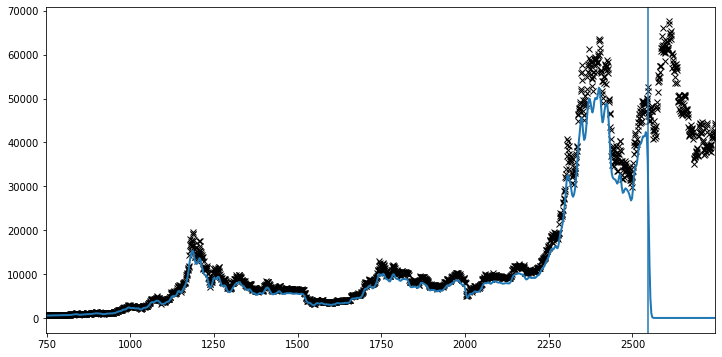

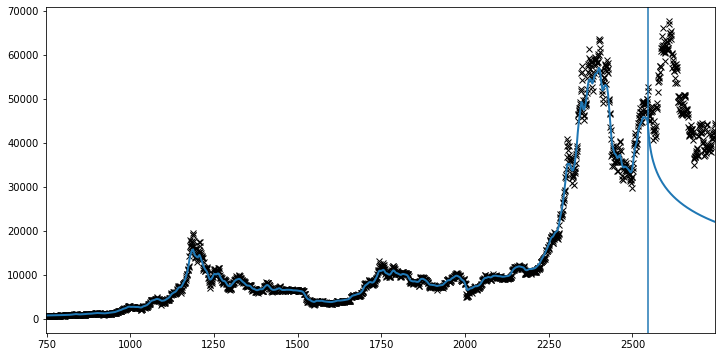

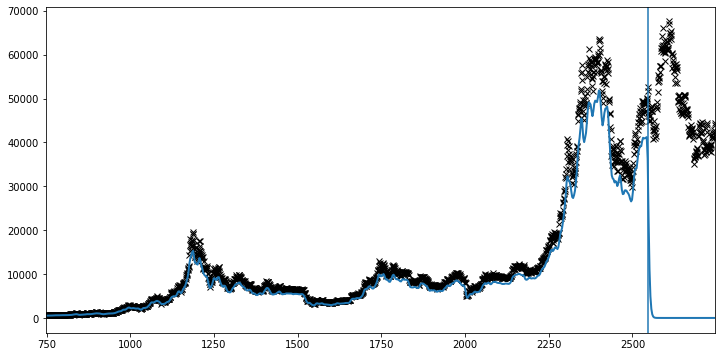

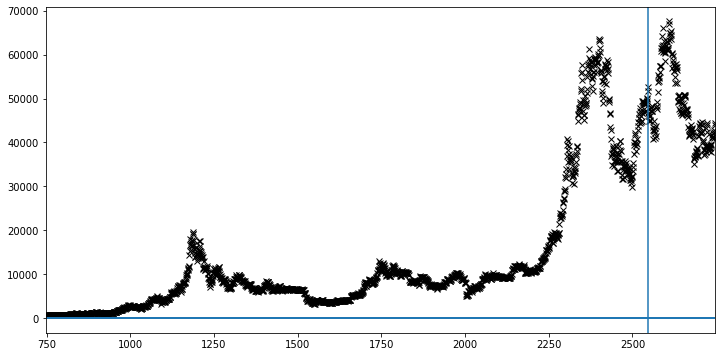

In [34]:
for i, model in enumerate(models_0):
  plot(X_full, y_full, model=model, plot_observed_data=True, plot_predictions=True, xlim=(len(data)-10*T0, len(data)), train_test_split=T0, n_test=1000)

100%|██████████| 4/4 [18:28<00:00, 277.00s/it]


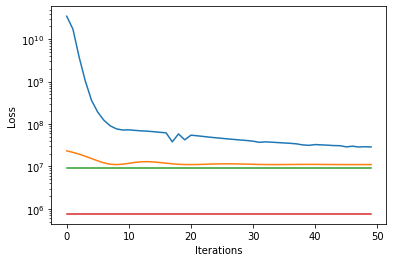

In [28]:
models = []
pyro.clear_param_store()

# Model 1: linear+RBF*periodic
kernel_1 = gp.kernels.Sum(
                          gp.kernels.Linear(input_dim=1),
                          gp.kernels.Product(
                              gp.kernels.Periodic(input_dim=1),
                              gp.kernels.RBF(input_dim=1)   
                              )
                          )
models.append(gp.models.GPRegression(X=X,y=y,kernel=kernel_1))

# Model 2: linear+RQ*periodic

kernel_2 = gp.kernels.Sum(
                          gp.kernels.Linear(input_dim=1),
                          gp.kernels.Product(
                              gp.kernels.Periodic(input_dim=1),
                              gp.kernels.RationalQuadratic(input_dim=1)   
                              )
                          )

models.append(gp.models.GPRegression(X=X,y=y,kernel=kernel_2))


# Model 3: linear+Mattern32*periodic

kernel_3 = gp.kernels.Sum(
                          gp.kernels.Linear(input_dim=1),
                          gp.kernels.Product(
                              gp.kernels.Periodic(input_dim=1),
                              gp.kernels.Matern32(input_dim=1)   
                              )
                          )
models.append(gp.models.GPRegression(X=X,y=y,kernel=kernel_3))


# Model 4: linear*RQ*periodic
kernel_4 = gp.kernels.Product(
                              gp.kernels.Periodic(input_dim=1),
                              gp.kernels.RationalQuadratic(input_dim=1)   
                              )
                      
models.append(gp.models.GPRegression(X=X,y=y,kernel=kernel_4))

# Model 5: RQ
kernel_5 = gp.kernels.RationalQuadratic(input_dim=1)   
                      
models.append(gp.models.GPRegression(X=X,y=y,kernel=kernel_5))




'''
# linear kernel adresses the optimistic scenario that the price will grow without interruptions
linear = gp.kernels.Linear(
    input_dim=1,
)

# periodic variations in the currency's behaviour
periodic = gp.kernels.Periodic(
    input_dim=1, period=torch.tensor([30]), lengthscale=torch.tensor(14.0)
)


rbf = gp.kernels.RBF(
    input_dim=1, lengthscale=torch.tensor(10), variance=torch.tensor(1)
)

rq = gp.kernels.RationalQuadratic(input_dim=1)


k1 = gp.kernels.Product(kern0=deepcopy(rbf), kern1=deepcopy(periodic))
rq_period = gp.kernels.Product(kern0=deepcopy(rq), kern1=deepcopy(periodic))

#white noise corresponding to the volatile nature of BTC
noise = gp.kernels.WhiteNoise(input_dim=1)

k = gp.kernels.Sum(deepcopy(linear), deepcopy(k1))
k_rq = gp.kernels.Sum(deepcopy(linear), deepcopy(rq_period))





kernels.append(gp.kernels.Sum(deepcopy(noise), deepcopy(k)))
kernels.append(gp.kernels.Sum(deepcopy(noise), deepcopy(k_rq)))

#kernels.append(deepcopy(k))
#kernels.append(deepcopy(k1))




for kernel_cand in kernels:
  models.append(gp.models.GPRegression(X=X,y=y,kernel=kernel_cand))
'''




for model in tqdm(models):
  loss = gp.util.train(model, num_steps=50, optimizer=torch.optim.Adam(model.parameters(), lr=0.5))
  plot_loss(loss, log=True)

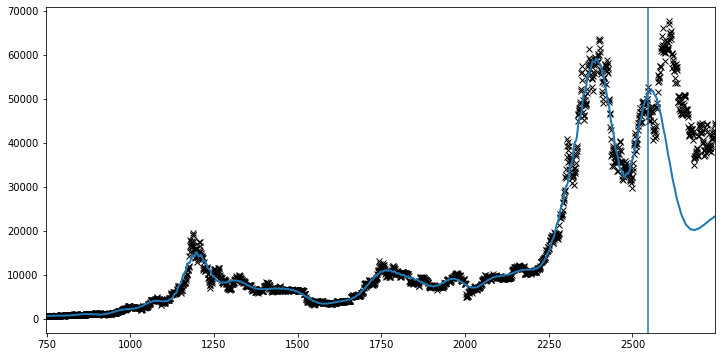

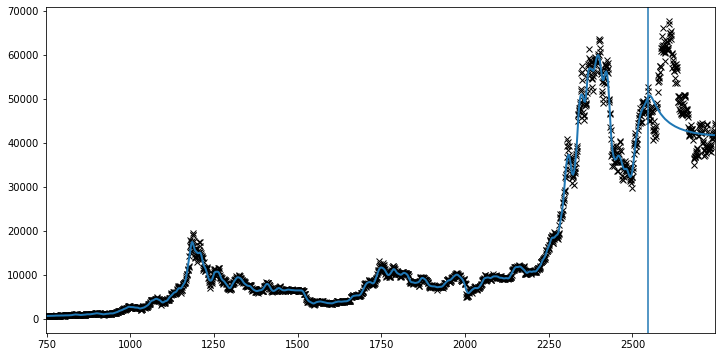

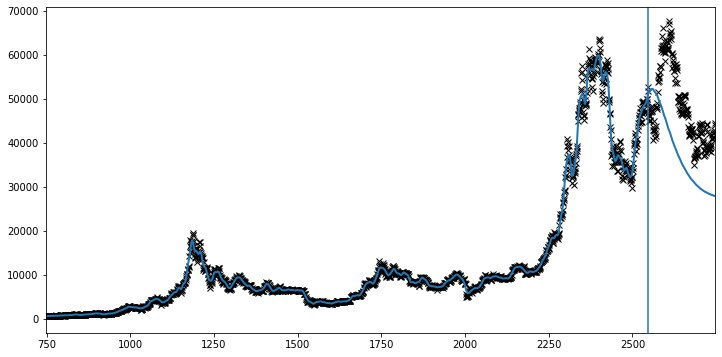

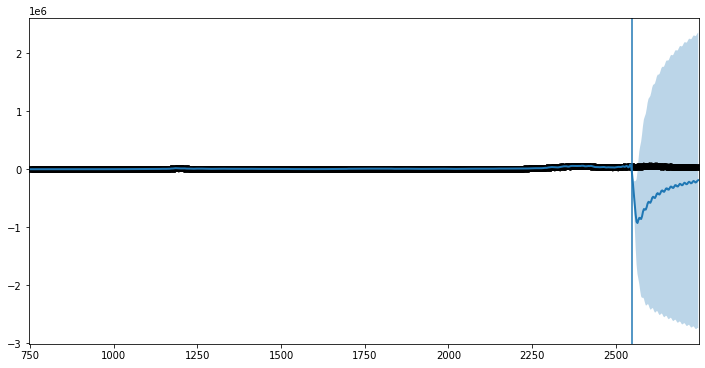

In [30]:
#colors = 'bgrcmyk'
#fig, ax = plt.subplots(figsize=(12, 6))
for i, model in enumerate(models):
  plot(X_full, y_full, model=model, plot_observed_data=True, plot_predictions=True, xlim=(len(data)-10*T0, len(data)), train_test_split=T0, n_test=1000)


In [19]:
tmp = models[0]

In [20]:
for ii in tmp.named_parameters():
  print(ii)

('noise_unconstrained', Parameter containing:
tensor(5.8640, dtype=torch.float64, requires_grad=True))
('kernel.kern0.variance_unconstrained', Parameter containing:
tensor(5.8640, requires_grad=True))
('kernel.kern1.kern0.variance_unconstrained', Parameter containing:
tensor(5.3455, requires_grad=True))
('kernel.kern1.kern1.kern0.variance_unconstrained', Parameter containing:
tensor(3.5460, requires_grad=True))
('kernel.kern1.kern1.kern0.lengthscale_unconstrained', Parameter containing:
tensor(4.9998, requires_grad=True))
('kernel.kern1.kern1.kern1.variance_unconstrained', Parameter containing:
tensor(3.5460, requires_grad=True))
('kernel.kern1.kern1.kern1.lengthscale_unconstrained', Parameter containing:
tensor(4.0351, requires_grad=True))
('kernel.kern1.kern1.kern1.period_unconstrained', Parameter containing:
tensor([3.6246], requires_grad=True))


In [21]:
models[0]

GPRegression(
  (kernel): Sum(
    (kern0): WhiteNoise()
    (kern1): Sum(
      (kern0): Linear()
      (kern1): Product(
        (kern0): RBF()
        (kern1): Periodic()
      )
    )
  )
)

In [26]:
models


[GPRegression(
   (kernel): Sum(
     (kern0): WhiteNoise()
     (kern1): Sum(
       (kern0): Linear()
       (kern1): Product(
         (kern0): RBF()
         (kern1): Periodic()
       )
     )
   )
 ), GPRegression(
   (kernel): Sum(
     (kern0): WhiteNoise()
     (kern1): Sum(
       (kern0): Linear()
       (kern1): Product(
         (kern0): RationalQuadratic()
         (kern1): Periodic()
       )
     )
   )
 ), GPRegression(
   (kernel): Sum(
     (kern0): Linear()
     (kern1): Product(
       (kern0): Periodic()
       (kern1): RBF()
     )
   )
 ), GPRegression(
   (kernel): Sum(
     (kern0): Linear()
     (kern1): Product(
       (kern0): Periodic()
       (kern1): RationalQuadratic()
     )
   )
 ), GPRegression(
   (kernel): Sum(
     (kern0): Linear()
     (kern1): Product(
       (kern0): Periodic()
       (kern1): Matern32()
     )
   )
 )]